In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
with open('run4_tele.log', 'r') as f:
    teles = f.readlines()
    
with open('run4_sol.log', 'r') as f:
    iopt_sols = f.readlines()
    
print('Number teles {}'.format(len(teles)))
print('Number sols  {}'.format(len(iopt_sols)))

Number teles 89
Number sols  89


In [3]:
def read_tele(tele):
    data = json.loads(tele)
    
    # way points
    ptsx = data[1]['ptsx']
    ptsy = data[1]['ptsy']
    
    # current state
    px = data[1]['x']
    py = data[1]['y']
    psi= data[1]['psi']
    v  = data[1]['speed']
    
    return (px, py, psi, v), (ptsx, ptsy)

def convert2carcoor(state, way_points):
    '''
    from current state and way_points, we convert to local-car's coordinate
    '''
    px, py, psi, v = state
    ptsx, ptsy = way_points
    
    cospsi = np.cos(psi)
    sinpsi = np.sin(psi)
    xvals  = []
    yvals  = []
    
    for x,y in zip(ptsx, ptsy):
        dx = x - px
        dy = y - py
        
        xvals.append(dx * cospsi + dy * sinpsi)
        yvals.append(-dx* sinpsi + dy * cospsi)
    
    return xvals, yvals

def convert2globcoor(state, xvals, yvals):
    px, py, psi, v = state
    ptsx = []
    ptsy = []
    
    cospsi = np.cos(psi)
    sinpsi = np.sin(psi)
    
    for x, y in zip(xvals, yvals):
        dx = x * cospsi - y * sinpsi
        dy = x * sinpsi + y * cospsi
        ptsx.append(px + dx)
        ptsy.append(py + dy)
        
    return ptsx, ptsy

def read_sol(sol):
    data = json.loads(sol)
    return data

def visualize(step_idx):
    plt.figure()
    state, way_points = read_tele(teles[step_idx])
    # convert into local car-coor then fit a polynomial
    xvals, yvals = convert2carcoor(state, way_points)
    coeffs = np.polyfit(xvals, yvals, 3)
    
    # read sol
    sol = read_sol(iopt_sols[step_idx])
    mpc_x, mpc_y = sol['mpc_x'], sol['mpc_y']
    
    xp = np.linspace(np.min(xvals), np.max(xvals))
    yp = np.polyval(coeffs, xp)
    px, py, psi, v = state    
    plt.scatter(0, 0, 100, c='g', marker='^', label='start')
    dt = 0.5
    vdt = v*dt
    plt.quiver(0, 0, vdt * np.cos(0), vdt * np.sin(0), angles='xy', scale_units='xy', scale=1)
    plt.scatter(xvals, yvals, label='ref points')
    plt.scatter(mpc_x, mpc_y, alpha=0.5, label='optimized trajectory')
    _=plt.plot(xp, yp, label='fitted poly')
    plt.xlim([np.min(mpc_x)-10, np.max(mpc_x)+30])
    plt.title('Step {}'.format(step_idx))
    plt.legend()


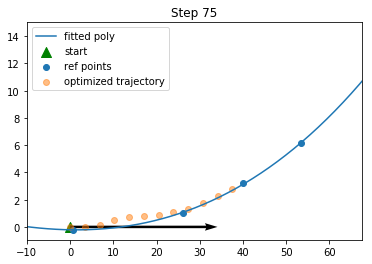

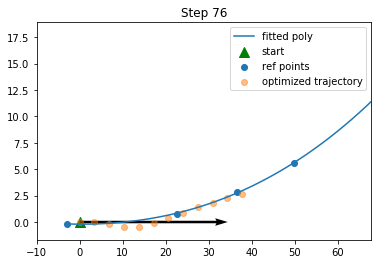

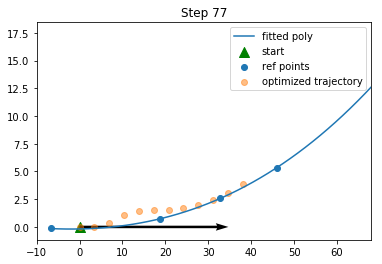

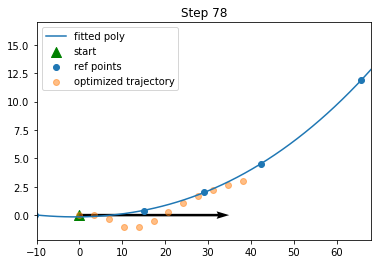

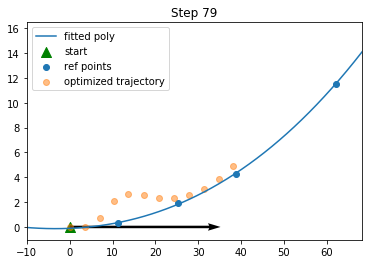

In [14]:
start_idx = 75
for i in range(start_idx, start_idx + 5):
    visualize(i)

In [18]:
def mpc_update(tele, sol, plot_it=True):
    state, way_points = read_tele(tele)
    xvals, yvals = convert2carcoor(state, way_points)
    coeffs = np.polyfit(xvals, yvals, 3)
    
    xp = np.linspace(np.min(xvals), np.max(xvals))
    yp = np.polyval(coeffs, xp)
    
    sol = read_sol(sol)
    
    # accelerator & turn rate
    accs   = sol['mpc_a']
    deltas = sol['mpc_delta']
    dt     = sol['dt']
    ref_v  = 80
    
    # compute error & trajectory
    x    = 0
    y    = 0
    psi  = 0
    v    = state[3]
    cte  = coeffs[0]
    epsi = -np.arctan(coeffs[1])
    
    mpc_x = [x]
    mpc_y = [y]
    ctes  = [cte]
    epsis = [epsi]
    vs    = [v]
    Lf    = 2.67
    pder  = np.polyder(np.poly1d(coeffs))
    
    for acc, delta in zip(accs, deltas):
        x1   = x + v * np.cos(psi) * dt
        y1   = y + v * np.sin(psi) * dt
        psi1 = psi - v * delta * dt / Lf
        v1   = v + acc *dt
        
        # reference line & heading
        f0 = np.polyval(coeffs, x)        
        h0 = np.arctan(pder(x))
        
        cte  = (f0  - y) + v * np.sin(epsi) * dt
        epsi = (psi - h0) - v * delta * dt / Lf
        
        ctes.append(cte)
        epsis.append(epsi)
        vs.append(v1)
        mpc_x.append(x1)
        mpc_y.append(y1)
        
        # update
        x   = x1
        y   = y1
        psi = psi1
        v   = v1
    
    cte_err  = 0.
    epsi_err = 0.
    v_err    = 0.
    a_mag    = 0.
    d_mag    = 0.
    a_diff   = 0.
    d_diff   = 0.
    N = len(ctes)
    for i in range(N):
        cte_err += ctes[i]**2
        epsi_err += epsis[i]**2
        v_err += (ref_v -vs[i])**2
        if i < N - 1:
            a_mag += accs[i]**2
            d_mag += deltas[i]**2
            
        if i < N - 2:
            a_diff += (accs[i+1] - accs[i])**2
            d_diff += (deltas[i+1] - deltas[i])**2
    
    if plot_it:
        plt.figure()
        plt.plot(np.arange(len(ctes)), ctes, label='cte')
        plt.legend()
        plt.figure()
        plt.plot(np.arange(len(epsis)), epsis, label='epsi')
        plt.legend()
        plt.figure()
        plt.plot(np.arange(len(deltas)), deltas, label='delta')
        plt.legend()
        plt.figure()
        plt.plot(np.arange(len(accs)), accs, label='accelerator')
        plt.legend()
        plt.figure()
        plt.scatter(xvals, yvals, label='ref points')
        plt.scatter(mpc_x, mpc_y, alpha=0.5, label='optimized trajectory')
        _=plt.plot(xp, yp, label='fitted poly')
        plt.xlim([np.min(mpc_x)-10, np.max(mpc_x)+30])
        plt.legend()
        
        # print some error
        print ('cte_err  = {}'.format(cte_err))
        print ('epsi_err = {}'.format(epsi_err))
        print ('v_err    = {}'.format(v_err))
        print ('a_mag    = {}'.format(a_mag))
        print ('d_mag    = {}'.format(d_mag))
        print ('a_diff   = {}'.format(a_diff))
        print ('d_diff   = {}'.format(d_diff))
        
    return cte_err, epsi_err, v_err, a_mag, d_mag, a_diff, d_diff

cte_err  = 16.489817745084025
epsi_err = 0.2669850079567196
v_err    = 1047.6921836043414
a_mag    = 10.159965483715116
d_mag    = 0.11424101096262704
a_diff   = 0.06112291907437657
d_diff   = 0.12410062095098859


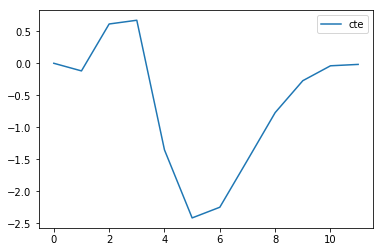

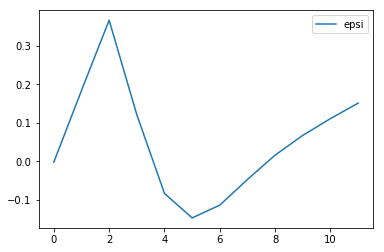

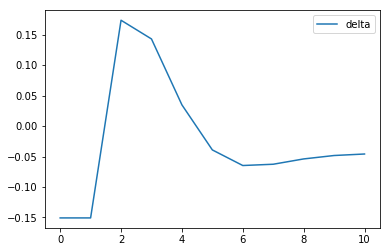

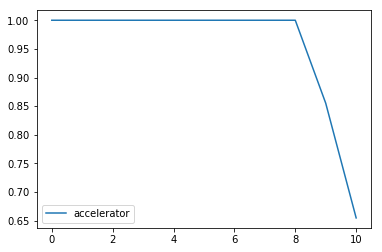

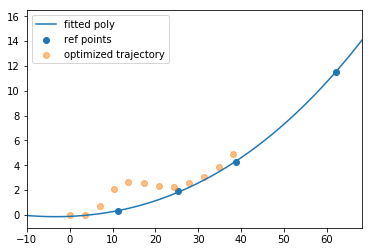

In [21]:
idx = 79
_ = mpc_update(teles[idx], iopt_sols[idx])

In [7]:
def visualize_err(teles, sols):
    N = len(teles)
    cte_errs   = []
    epsi_errs  = []
    v_errs     = []
    a_mags     = []
    d_mags     = []
    a_diffs    = []
    d_diffs    = []
    for i in range(N):
        cte_err, epsi_err, v_err, a_mag, d_mag, a_diff, d_diff = mpc_update(teles[i], sols[i], False)
        cte_errs.append(cte_err)
        epsi_errs.append(epsi_err)
        v_errs.append(v_err)
        a_mags.append(a_mag)
        d_mags.append(d_mag)
        a_diffs.append(a_diff)
        d_diffs.append(d_diff)
        
    plt.figure()
    plt.plot(np.arange(len(v_errs)), v_errs, label='v-errs')
    plt.legend()
    
    plt.figure()
    plt.plot(np.arange(len(cte_errs)), cte_errs, label='cte')
    plt.plot(np.arange(len(epsi_errs)), epsi_errs, label='epsi')    
    plt.legend()
    plt.figure()
    plt.plot(np.arange(len(a_mags)), a_mags, label='acc magnitude')
    plt.plot(np.arange(len(d_mags)), d_mags, label='delta magnitude')
    plt.legend()
    
    plt.figure()        
    plt.plot(np.arange(len(a_diffs)), a_diffs, label='acc difference')    
    plt.plot(np.arange(len(d_diffs)), d_diffs, label='delta difference')
    plt.legend()
    

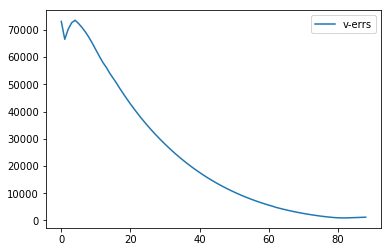

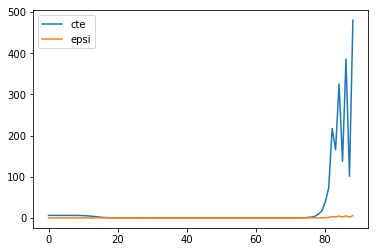

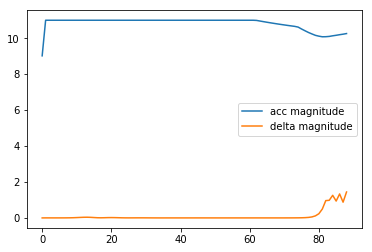

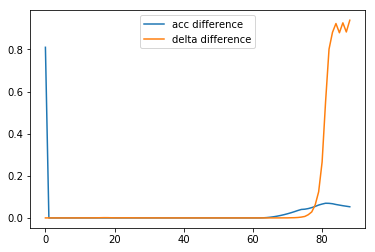

In [19]:
start_idx = 0
visualize_err(teles[start_idx:], iopt_sols[start_idx:])